# QSO分组问题

In [1]:
import sys
sys.path.append("src")
import os
import json

import libpybiofeature

import utils
work_Dir = utils.workdir.workdir(os.getcwd(), 4)

import numpy as np
import pandas as pd

In [2]:
def load_QSO_feature(TxSE_args: dict):

    # Extract Feature
    seq_id_dict = None
    with open(TxSE_args['seq_id'], 'r', encoding='UTF-8') as f:
        seq_id_dict = json.load(f)

    # QSO
    QSO_feature = {
        "name": "QSO",
        "t_p": libpybiofeature.featurebuilder.build_qso_feature(
            path_to_fasta=TxSE_args['fasta']['t']['p'],
            seq_id_list=seq_id_dict['t']['p'],
            desc='t_p',
            cter=TxSE_args['fasta']['cter']
        ),
        "t_n": libpybiofeature.featurebuilder.build_qso_feature(
            path_to_fasta=TxSE_args['fasta']['t']['n'],
            seq_id_list=seq_id_dict['t']['n'],
            desc='t_n',
            cter=TxSE_args['fasta']['cter']
        ),
        "v_p": libpybiofeature.featurebuilder.build_qso_feature(
            path_to_fasta=TxSE_args['fasta']['v']['p'],
            seq_id_list=seq_id_dict['v']['p'],
            desc='v_p',
            cter=TxSE_args['fasta']['cter']
        ),
        "v_n": libpybiofeature.featurebuilder.build_qso_feature(
            path_to_fasta=TxSE_args['fasta']['v']['n'],
            seq_id_list=seq_id_dict['v']['n'],
            desc='v_n',
            cter=TxSE_args['fasta']['cter']
        ),
    }

    QSO_feature['p'] = pd.concat([
        QSO_feature['t_p'],
        QSO_feature['v_p'],
    ])
    QSO_feature['n'] = pd.concat([
        QSO_feature['t_n'],
        QSO_feature['v_n'],
    ])

    return QSO_feature

In [3]:
prot_type = 2
cter_bool = False
Tx_arg = {
    "type": f'T{prot_type}',
    'seq_id': os.path.join(work_Dir, *['data', 'db', f'T{prot_type}', 'seq_id.json']),
    'fasta': {
        'cter': cter_bool,
        't': {
            'p': os.path.join(work_Dir, *['data', 'db', f'T{prot_type}', 't_p.fasta']),
            'n': os.path.join(work_Dir, *['data', 'db', f'T{prot_type}', 't_n.fasta'])
        },
        'v': {
            'p': os.path.join(work_Dir, *['data', 'db', f'T{prot_type}', 'v_p.fasta']),
            'n': os.path.join(work_Dir, *['data', 'db', f'T{prot_type}', 'v_n.fasta'])
        },
    },
}
save_dir = "out/libfeatureselection/Second_feature_research/qso/origin/"

In [4]:
qso_data = load_QSO_feature(
    TxSE_args=Tx_arg
)
columns_type = list(qso_data['p'].columns)

v_n_QSO: 100%|██████████| 20/20 [00:00<00:00, 216.95it/s]


In [5]:
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.use14corefonts'] = False
# mpl.rcParams['pdf.usecorefonts'] = True
mpl.rcParams['pdf.compression'] = 9

import matplotlib.pyplot as plt
import scienceplots

plt.style.use(['science', 'nature'])

from matplotlib.ticker import MaxNLocator
from matplotlib.gridspec import GridSpec

import seaborn as sns

In [6]:
qso_data_transformed = pd.concat([qso_data['p'], qso_data['n']], keys=['T1SP', 'non-T1SP']).reset_index(level=0).rename({
    "level_0": "Type"
}, axis=1, inplace=False).melt(id_vars="Type", value_vars=columns_type, ignore_index=False).rename({
    "variable": "Columns",
    "value": "QSO"
}, axis=1, inplace=False)
qso_data_transformed['Columns'] = qso_data_transformed['Columns'].str.replace(r'Schneider', 'S', regex=True).replace(r'Grantham', 'G', regex=True)

In [7]:
qso_data_transformed

,Type,Columns,QSO
sp|Q7MDS1|Q7MDS1_VIBVY,T1SP,S.Xr.A,0.057366
sp|Q9KLD4|Q9KLD4_VIBCH,T1SP,S.Xr.A,0.069473
YP_109991.1,T1SP,S.Xr.A,0.086592
sp|Q9KSH6|Q9KSH6_VIBCH,T1SP,S.Xr.A,0.088141
sp|P10480.3|GCAT_AERHY,T1SP,S.Xr.A,0.121711
...,...,...,...
lcl|NC_007712.1_prot_1918,non-T1SP,G.Xd.30,0.032908
lcl|NC_014931.1_prot_WP_013542437.1_4030,non-T1SP,G.Xd.30,0.033325
Bor_Bor_BopN|CAE32113.1,non-T1SP,G.Xd.30,0.031578
lcl|NC_015470.1_prot_WP_006343164.1_483,non-T1SP,G.Xd.30,0.025249


In [8]:
def get_star(p:float):
    if p <= 0.0001:
        return "****"
    elif p <= 0.001:
        return "***"
    elif p <= 0.01:
        return "**"
    elif p <= 0.05:
        return "*"
    else:
        return ""
from scipy.stats import wilcoxon
grouped = qso_data_transformed.groupby("Columns")
wilcoxon_result = {}
for name, group in grouped:
    x = group[group['Type'] == 'T1SP']['QSO']
    y = group[group['Type'] == 'non-T1SP']['QSO']
    stat, p = wilcoxon(x, y)
    wilcoxon_result[name] = {
        "statistic": stat,
        "p-value": p
    }
    # print(f'Type: {name}, Wilcoxon rank-sum statistic: {stat:.2f}, p-value: {p:.3f}')
with open(f"{save_dir}/wilcoxon_result.json", "w+", encoding="UTF-8") as f:
    json.dump(wilcoxon_result, f)
qso_data_transformed.to_csv(f"{save_dir}/qso_data_transformed.csv", index_label="Seq_ID")

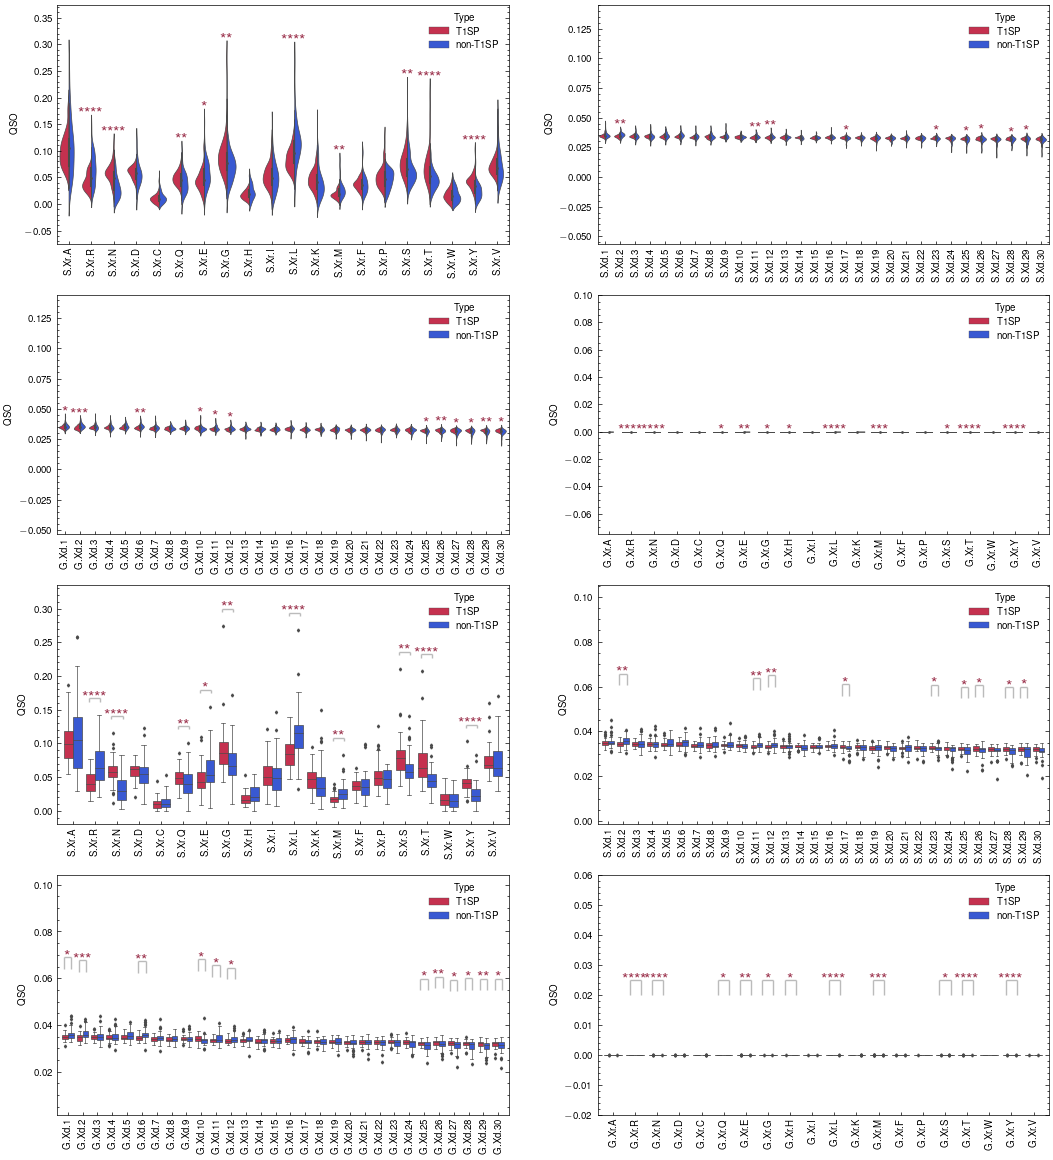

In [9]:
ncols = 2
nrow = 4
fig = plt.figure(
    constrained_layout=True,
    figsize=(19.2 / 4 * 1.35 * ncols, 10.8 / 4 * 1.35 * nrow)
)
gs = GridSpec(nrow, ncols, figure=fig)

# Schneider.Xr
qso_data_transformed_Schneider = qso_data_transformed[
    qso_data_transformed['Columns'].str.contains(r'S\.Xr\.\w', regex=True)
]

ax1_Schneider = fig.add_subplot(gs[0, 0])

sns.violinplot(
    data=qso_data_transformed_Schneider,
    x="Columns",
    y="QSO",
    hue="Type",
    split=True,
    linewidth=0.5,
    palette=["#dd1940", "#1f4aec"],
    ax=ax1_Schneider
)
ax1_Schneider.set_ylim([qso_data_transformed_Schneider['QSO'].min() - 0.075, qso_data_transformed_Schneider['QSO'].max() + 0.1])
ax_xticklabel_origin = ax1_Schneider.get_xticklabels()
ax_xticklabel = [ item._text for item in ax_xticklabel_origin ]
ax1_Schneider.tick_params(axis='x', length=2, top=False, rotation=90)
ax1_Schneider.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(1))
ax1_Schneider.set_xlabel("")

for i, (violin_1, violin_2) in enumerate(zip(ax1_Schneider.collections[0::3], ax1_Schneider.collections[2::3])):
    center = violin_1.get_paths()[0].vertices[:, 0].mean()
    height = max(violin_1.get_paths()[0].vertices[:, 1].max(), violin_2.get_paths()[0].vertices[:, 1].max())
    ax1_Schneider.text(i, height, get_star(
        p = wilcoxon_result[ax_xticklabel[i]]["p-value"]
    ), fontsize=12, color="#9b324c", ha='center', va='center')

ax2_Schneider = fig.add_subplot(gs[2, 0])

sns.boxplot(
    data=qso_data_transformed_Schneider,
    x="Columns",
    y="QSO",
    hue="Type",
    linewidth=0.5,
    palette=["#dd1940", "#1f4aec"],
    fliersize=1.5,
    ax=ax2_Schneider
)
ax2_Schneider.set_ylim([qso_data_transformed_Schneider['QSO'].min() - 0.02, qso_data_transformed_Schneider['QSO'].max() + 0.06])
ax_xticklabel_origin = ax2_Schneider.get_xticklabels()
ax_xticklabel = [ item._text for item in ax_xticklabel_origin ]
ax2_Schneider.tick_params(axis='x', length=2, top=False, )
ax2_Schneider.tick_params(axis='x', rotation=90)
ax2_Schneider.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(1))
ax2_Schneider.set_xlabel("")

for i, aa in enumerate(ax_xticklabel):
    center = i
    height = max(qso_data_transformed_Schneider[qso_data_transformed_Schneider["Columns"] == aa]['QSO']) + 0.025
    star_str = get_star(
        p = wilcoxon_result[aa]["p-value"]
    )
    if "*" in star_str:
        ax2_Schneider.text(center, height, star_str, fontsize=12, color="#9b324c", ha='center', va='center')
        ax2_Schneider.hlines(height,center-0.25,center+0.25, color="#bbbbbb")
        ax2_Schneider.vlines(center-0.25,height-0.005, height, color="#bbbbbb")
        ax2_Schneider.vlines(center+0.25,height-0.005, height, color="#bbbbbb")

# Schneider.Xd
qso_data_transformed_SchneiderXd = qso_data_transformed[
    qso_data_transformed['Columns'].str.contains(r'S\.Xd\.\d+', regex=True)
]

ax1_Schneider = fig.add_subplot(gs[0, 1])

sns.violinplot(
    data=qso_data_transformed_SchneiderXd,
    x="Columns",
    y="QSO",
    hue="Type",
    split=True,
    linewidth=0.5,
    palette=["#dd1940", "#1f4aec"],
    ax=ax1_Schneider
)
ax1_Schneider.set_ylim([qso_data_transformed_SchneiderXd['QSO'].min() - 0.075, qso_data_transformed_SchneiderXd['QSO'].max() + 0.1])
ax_xticklabel_origin = ax1_Schneider.get_xticklabels()
ax_xticklabel = [ item._text for item in ax_xticklabel_origin ]
ax1_Schneider.tick_params(axis='x', length=2, top=False, rotation=90)
ax1_Schneider.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(1))
ax1_Schneider.set_xlabel("")

for i, (violin_1, violin_2) in enumerate(zip(ax1_Schneider.collections[0::3], ax1_Schneider.collections[2::3])):
    center = violin_1.get_paths()[0].vertices[:, 0].mean()
    height = max(violin_1.get_paths()[0].vertices[:, 1].max(), violin_2.get_paths()[0].vertices[:, 1].max())
    ax1_Schneider.text(i, height, get_star(
        p = wilcoxon_result[ax_xticklabel[i]]["p-value"]
    ), fontsize=12, color="#9b324c", ha='center', va='center')

ax2_Schneider = fig.add_subplot(gs[2, 1])

sns.boxplot(
    data=qso_data_transformed_SchneiderXd,
    x="Columns",
    y="QSO",
    hue="Type",
    linewidth=0.5,
    palette=["#dd1940", "#1f4aec"],
    fliersize=1.5,
    ax=ax2_Schneider
)
ax2_Schneider.set_ylim([qso_data_transformed_SchneiderXd['QSO'].min() - 0.02, qso_data_transformed_SchneiderXd['QSO'].max() + 0.06])
ax_xticklabel_origin = ax2_Schneider.get_xticklabels()
ax_xticklabel = [ item._text for item in ax_xticklabel_origin ]
ax2_Schneider.tick_params(axis='x', length=2, top=False, )
ax2_Schneider.tick_params(axis='x', rotation=90)
ax2_Schneider.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(1))
ax2_Schneider.set_xlabel("")

for i, aa in enumerate(ax_xticklabel):
    center = i
    height = max(qso_data_transformed_SchneiderXd[qso_data_transformed_SchneiderXd["Columns"] == aa]['QSO']) + 0.025
    star_str = get_star(
        p = wilcoxon_result[aa]["p-value"]
    )
    if "*" in star_str:
        ax2_Schneider.text(center, height, star_str, fontsize=12, color="#9b324c", ha='center', va='center')
        ax2_Schneider.hlines(height,center-0.25,center+0.25, color="#bbbbbb")
        ax2_Schneider.vlines(center-0.25,height-0.005, height, color="#bbbbbb")
        ax2_Schneider.vlines(center+0.25,height-0.005, height, color="#bbbbbb")

# Grantham.Xd
qso_data_transformed_GranthamXd = qso_data_transformed[
    qso_data_transformed['Columns'].str.contains(r'G\.Xd\.\d+', regex=True)
]

ax1_Schneider = fig.add_subplot(gs[1, 0])

sns.violinplot(
    data=qso_data_transformed_GranthamXd,
    x="Columns",
    y="QSO",
    hue="Type",
    split=True,
    linewidth=0.5,
    palette=["#dd1940", "#1f4aec"],
    ax=ax1_Schneider
)
ax1_Schneider.set_ylim([qso_data_transformed_GranthamXd['QSO'].min() - 0.075, qso_data_transformed_GranthamXd['QSO'].max() + 0.1])
ax_xticklabel_origin = ax1_Schneider.get_xticklabels()
ax_xticklabel = [ item._text for item in ax_xticklabel_origin ]
ax1_Schneider.tick_params(axis='x', length=2, top=False, rotation=90)
ax1_Schneider.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(1))
ax1_Schneider.set_xlabel("")

for i, (violin_1, violin_2) in enumerate(zip(ax1_Schneider.collections[0::3], ax1_Schneider.collections[2::3])):
    center = violin_1.get_paths()[0].vertices[:, 0].mean()
    height = max(violin_1.get_paths()[0].vertices[:, 1].max(), violin_2.get_paths()[0].vertices[:, 1].max())
    ax1_Schneider.text(i, height, get_star(
        p = wilcoxon_result[ax_xticklabel[i]]["p-value"]
    ), fontsize=12, color="#9b324c", ha='center', va='center')

ax2_Schneider = fig.add_subplot(gs[3, 0])

sns.boxplot(
    data=qso_data_transformed_GranthamXd,
    x="Columns",
    y="QSO",
    hue="Type",
    linewidth=0.5,
    palette=["#dd1940", "#1f4aec"],
    fliersize=1.5,
    ax=ax2_Schneider
)
ax2_Schneider.set_ylim([qso_data_transformed_GranthamXd['QSO'].min() - 0.02, qso_data_transformed_GranthamXd['QSO'].max() + 0.06])
ax_xticklabel_origin = ax2_Schneider.get_xticklabels()
ax_xticklabel = [ item._text for item in ax_xticklabel_origin ]
ax2_Schneider.tick_params(axis='x', length=2, top=False, )
ax2_Schneider.tick_params(axis='x', rotation=90)
ax2_Schneider.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(1))
ax2_Schneider.set_xlabel("")

for i, aa in enumerate(ax_xticklabel):
    center = i
    height = max(qso_data_transformed_GranthamXd[qso_data_transformed_GranthamXd["Columns"] == aa]['QSO']) + 0.025
    star_str = get_star(
        p = wilcoxon_result[aa]["p-value"]
    )
    if "*" in star_str:
        ax2_Schneider.text(center, height, star_str, fontsize=12, color="#9b324c", ha='center', va='center')
        ax2_Schneider.hlines(height,center-0.25,center+0.25, color="#bbbbbb")
        ax2_Schneider.vlines(center-0.25,height-0.005, height, color="#bbbbbb")
        ax2_Schneider.vlines(center+0.25,height-0.005, height, color="#bbbbbb")

# Grantham.Xr
qso_data_transformed_GranthamXr = qso_data_transformed[
    qso_data_transformed['Columns'].str.contains(r'G\.Xr\.\w', regex=True)
]

ax1_Schneider = fig.add_subplot(gs[1, 1])

sns.violinplot(
    data=qso_data_transformed_GranthamXr,
    x="Columns",
    y="QSO",
    hue="Type",
    split=True,
    linewidth=0.5,
    palette=["#dd1940", "#1f4aec"],
    ax=ax1_Schneider
)
ax1_Schneider.set_ylim([qso_data_transformed_GranthamXr['QSO'].min() - 0.075, qso_data_transformed_GranthamXr['QSO'].max() + 0.1])
ax_xticklabel_origin = ax1_Schneider.get_xticklabels()
ax_xticklabel = [ item._text for item in ax_xticklabel_origin ]
ax1_Schneider.tick_params(axis='x', length=2, top=False, rotation=90)
ax1_Schneider.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(1))
ax1_Schneider.set_xlabel("")

for i, (violin_1, violin_2) in enumerate(zip(ax1_Schneider.collections[0::3], ax1_Schneider.collections[2::3])):
    center = violin_1.get_paths()[0].vertices[:, 0].mean()
    height = max(violin_1.get_paths()[0].vertices[:, 1].max(), violin_2.get_paths()[0].vertices[:, 1].max())
    ax1_Schneider.text(i, height, get_star(
        p = wilcoxon_result[ax_xticklabel[i]]["p-value"]
    ), fontsize=12, color="#9b324c", ha='center', va='center')

ax2_Schneider = fig.add_subplot(gs[3, 1])

sns.boxplot(
    data=qso_data_transformed_GranthamXr,
    x="Columns",
    y="QSO",
    hue="Type",
    linewidth=0.5,
    palette=["#dd1940", "#1f4aec"],
    fliersize=1.5,
    ax=ax2_Schneider
)
ax2_Schneider.set_ylim([qso_data_transformed_GranthamXr['QSO'].min() - 0.02, qso_data_transformed_GranthamXr['QSO'].max() + 0.06])
ax_xticklabel_origin = ax2_Schneider.get_xticklabels()
ax_xticklabel = [ item._text for item in ax_xticklabel_origin ]
ax2_Schneider.tick_params(axis='x', length=2, top=False, )
ax2_Schneider.tick_params(axis='x', rotation=90)
ax2_Schneider.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(1))
ax2_Schneider.set_xlabel("")

for i, aa in enumerate(ax_xticklabel):
    center = i
    height = max(qso_data_transformed_GranthamXr[qso_data_transformed_GranthamXr["Columns"] == aa]['QSO']) + 0.025
    star_str = get_star(
        p = wilcoxon_result[aa]["p-value"]
    )
    if "*" in star_str:
        ax2_Schneider.text(center, height, star_str, fontsize=12, color="#9b324c", ha='center', va='center')
        ax2_Schneider.hlines(height,center-0.25,center+0.25, color="#bbbbbb")
        ax2_Schneider.vlines(center-0.25,height-0.005, height, color="#bbbbbb")
        ax2_Schneider.vlines(center+0.25,height-0.005, height, color="#bbbbbb")


# plt.title("AAC Training-Testing Wilcoxon Signed Ranks Test")
plt.savefig(f"{save_dir}/diff.pdf")
plt.tight_layout()
plt.show()